# Semi-Supervised VAE Project
## By VAEGen

## Setup

### Import libraries

In [43]:
import os
import time
import torch
import argparse
from functools import reduce
# 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Torch
import torch
from torch.distributions import Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

### Meta parameters

In [44]:
batch_size=32*8*2
epochs=5
learning_rate=1e-3
latent_dim = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
#print layers, used for debugging
NNprint_ = False
classes=[0,1,2,3,4]
num_classes=len(classes)

### Import MNIST Dataset

In [45]:
# transforms arrays into tensors, can be extended
transformations = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Lambda(lambda p: Bernoulli(probs=p).sample())])

# define the train and test sets
dset_train = MNIST(root='data', train=True,  transform=transformations, download=True)
dset_test  = MNIST(root='data', train=False, transform=transformations)

def stratified_sampler(labels,classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets,classes))
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets,classes))

### Import FashionMNIST Dataset

In [46]:
train = FashionMNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=True)
test= FashionMNIST(
    root='data', train=False, transform=transforms.ToTensor(),
    download=False)

### Configure Loaders

In [47]:
train_loader = torch.utils.data.DataLoader(
  train,
  batch_size=batch_size,sampler=stratified_sampler(train.targets,classes))

test_loader = torch.utils.data.DataLoader(
  test,
  batch_size=batch_size,sampler=stratified_sampler(test.targets,classes))

In [48]:
#https://github.com/wohlert/semi-supervised-pytorch/blob/master/semi-supervised/utils.py
def onehot(k):
    """
    Converts a number to its one-hot or 1-of-k representation
    vector.
    :param k: (int) length of vector
    :return: onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode

In [49]:
n_labels = 10
def get_mnist(location="./data", batch_size=64, labels_per_class=100):
    from functools import reduce
    from operator import __or__
    from torch.utils.data.sampler import SubsetRandomSampler
    from torchvision.datasets import MNIST
    import torchvision.transforms as transforms

    flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1).bernoulli()

    mnist_train = MNIST(location, train=True, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))

    def get_sampler(labels, n=None):
        # Only choose digits in n_labels
        (indices,) = np.where(reduce(__or__, [labels == i for i in np.arange(n_labels)]))

        # Ensure uniform distribution of labels
        np.random.shuffle(indices)
        indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(n_labels)])

        indices = torch.from_numpy(indices)
        sampler = SubsetRandomSampler(indices)
        return sampler

    # Dataloaders for MNIST
    labelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, pin_memory=device,
                                           sampler=get_sampler(mnist_train.train_labels.numpy(), labels_per_class))
    unlabelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, pin_memory=device,
                                             sampler=get_sampler(mnist_train.train_labels.numpy()))
    validation = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, num_workers=2, pin_memory=device,
                                             sampler=get_sampler(mnist_valid.test_labels.numpy()))

    return labelled, unlabelled, validation

In [50]:
labelled, unlabelled, validation = get_mnist(location="./data", batch_size=64, labels_per_class=10)

/home/benjamin/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/benjamin/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [51]:

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data[0].shape)

torch.Size([1, 28, 28])


### Plot examples

In [52]:

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
def plot_examples(model=None,sample=False,data=None):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            batch_idx, (data, example_targets) = next(examples)
            if sample:
                zeros=torch.zeros(num_classes,1024)
                samples= torch.cat((torch.rand(latent_dim,1024),zeros)).T
                data = model.sample(samples.to(device))
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
            print(data[i][0].shape)
            plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([2

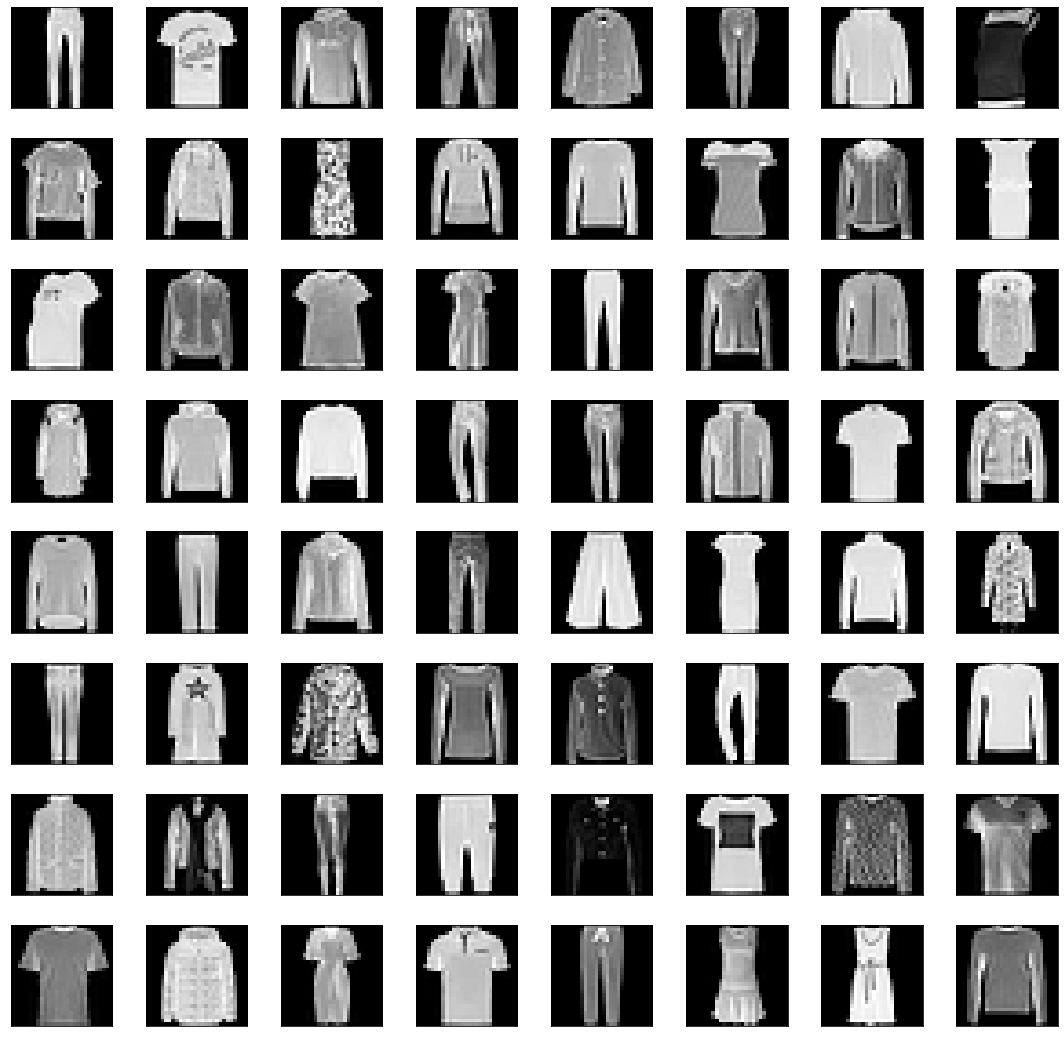

In [53]:
plot_examples()

### Torch auxiliary modules

In [54]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

# Debugging module 
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input  

## Deep Generative Model
Input: unlabeled data $[(x_v,)]$ and labeled data $[(x_s,y_s)]$
1. Run VAE on $[x_v + x_s]$.
2. Create linear classifier with input of latent vector size and output equal to number of classes.
3. Train classifier on $(\mu_s,y_s)$ where $\mu_s = vae.encode(x_s).\mu$

In [55]:
class Classifier(torch.nn.Module):
    def __init__(self, dimensions):
        # Input dimensions is 3 item tuple: in_dim, hidden_dim, out_dim
        super(Classifier,self).__init__()
        self.l1 = torch.nn.Linear(dimensions[0],dimensions[1])
        self.l2 = torch.nn.Linear(dimensions[1],dimensions[2])
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x))
        return x
    
clas = Classifier((10,10,5))
print(clas)

Classifier(
  (l1): Linear(in_features=10, out_features=10, bias=True)
  (l2): Linear(in_features=10, out_features=5, bias=True)
)


In [56]:
class Encoder(torch.nn.Module):
    def __init__(self, image_channels=1):
        super(Encoder, self).__init__()
        self.encode = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            Flatten(),            
            NNprint(),
        )
        
    def forward(self, x):
            return self.encode(x)
    
class Decoder(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024):
        super(Decoder, self).__init__()
        self.decode = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )
    def forward(self, x):
            return self.decode(x)
    
    
    
enc = Encoder()
print(enc)


dec = Decoder()
print(dec)
    
    


Encoder(
  (encode): Sequential(
    (0): NNprint()
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (2): NNprint()
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): NNprint()
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): NNprint()
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): NNprint()
    (12): LeakyReLU(negative_slope=0.01)
    (13): Flatten()
    (14): NNprint()
  )
)
Decoder(
  (decode): Sequential(
    (0): NNprint()
    (1): UnFlatten()
    (2): NNprint()
    (3): ConvTranspose2d(1024, 128, kernel_size=(4, 4), stride=(2, 2))
    (4): LeakyReLU(negative_slope=0.01)
    (5): NNprint()
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0.01)
    (8): NNprint()
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
    (10

In [84]:
class VAEGenModel(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32,num_labels=0,categories=10):
        super(VAEGenModel, self).__init__()
        self.y_dim = 10
        #Encoder
        self.encoder = Encoder(image_channels)
        #Decoder
        self.decoder = Decoder(image_channels, h_dim)
        #Classifier
        self.classifier = Classifier((z_dim, 200, categories))

        self.h_dim=h_dim
        self.num_labels=num_labels
        self.mu_l = torch.nn.Linear(h_dim, z_dim)
        self.logvar_l = torch.nn.Linear(h_dim, z_dim)
        self.reconstruction = torch.nn.Linear(z_dim+num_labels, h_dim)


    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * esp.to(device)
        return z
    
    def bottleneck(self, h,labels):
        mu, logvar = self.mu_l(h), self.logvar_l(h)
        z = self.reparameterize(mu, logvar)
        if self.num_labels>0:
            z=torch.cat((z,torch.nn.functional.one_hot(labels,self.num_labels).type(torch.float).to(device)),1)
        return z #, mu, logvar

    def encode(self, x,labels):
        h = self.encoder.forward(x)
#         h=torch.cat((h,labels.float().reshape(labels.size(0),1).to(device)),dim=1)
        z = self.bottleneck(h,labels)
        return z

    def decode(self, z):
        z = self.reconstruction(z)
        z = self.decoder.forward(z)
        return z

    def forward(self, x, labels):
        z = self.encode(x,labels)
        
        z = self.decode(z)
        return z, self.mu_l, self.logvar_l
    
    
    def elbo(self,recon_x, x):
        logvar = self.logvar_l
        mu = self.mu_l
        BCE = F.binary_cross_entropy(recon_x, x.to(device), size_average=False,reduction='sum' )
        # BCE = F.mse_loss(recon_x, x, size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = 0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE - KLD, BCE, KLD

    
    def elbo(self,recon_x, x):
        logvar = self.logvar_l
        mu = self.mu_l
        BCE = F.binary_cross_entropy(recon_x, x.to(device), size_average=False,reduction='sum' )
        # BCE = F.mse_loss(recon_x, x, size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = 0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE - KLD, BCE, KLD
    
    def kld(self,recon_x, x):
        logvar = self.logvar_l
        mu = self.mu_l
        KLD = 0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return KLD
    
    
    def sample(self,z):
        return self.decoder.forward(z)
    
    
vae = VAEGenModel()
print(vae)

VAEGenModel(
  (encoder): Encoder(
    (encode): Sequential(
      (0): NNprint()
      (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
      (2): NNprint()
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (5): NNprint()
      (6): LeakyReLU(negative_slope=0.01)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (8): NNprint()
      (9): LeakyReLU(negative_slope=0.01)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (11): NNprint()
      (12): LeakyReLU(negative_slope=0.01)
      (13): Flatten()
      (14): NNprint()
    )
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): NNprint()
      (1): UnFlatten()
      (2): NNprint()
      (3): ConvTranspose2d(1024, 128, kernel_size=(4, 4), stride=(2, 2))
      (4): LeakyReLU(negative_slope=0.01)
      (5): NNprint()
      (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
      (7): LeakyReLU(negative_slope=0.01)
 

In [85]:
def enumerate_discrete(x, y_dim):
    """
    Generates a `torch.Tensor` of size batch_size x n_labels of
    the given label.
    Example: generate_label(2, 1, 3) #=> torch.Tensor([[0, 1, 0],
                                                       [0, 1, 0]])
    :param x: tensor with batch size to mimic
    :param y_dim: number of total labels
    :return variable
    """
    def batch(batch_size, label):
        labels = (torch.ones(batch_size, 1) * label).type(torch.LongTensor)
        y = torch.zeros((batch_size, y_dim))
        y.scatter_(1, labels, 1)
        return y.type(torch.LongTensor)

    batch_size = x.size(0)
    generated = torch.cat([batch(batch_size, i) for i in range(y_dim)])

    if x.is_cuda:
        generated = generated.cuda()

    return generated.float()

def log_standard_categorical(p):
    """
    Calculates the cross entropy between a (one-hot) categorical vector
    and a standard (uniform) categorical distribution.
    :param p: one-hot categorical distribution
    :return: H(p, u)
    """
    # Uniform prior over y
    prior = F.softmax(torch.ones_like(p), dim=1)
    prior.requires_grad = False

    cross_entropy = -torch.sum(p * torch.log(prior + 1e-8), dim=1)

    return cross_entropy


class ImportanceWeightedSampler(object):
    """
    Importance weighted sampler [Burda 2015] to
    be used in conjunction with SVI.
    """
    def __init__(self, mc=1, iw=1):
        """
        Initialise a new sampler.
        :param mc: number of Monte Carlo samples
        :param iw: number of Importance Weighted samples
        """
        self.mc = mc
        self.iw = iw

    def resample(self, x):
        return x.repeat(self.mc * self.iw, 1)

    def __call__(self, elbo):
        elbo = elbo.view(self.mc, self.iw, -1)
        elbo = torch.mean(log_sum_exp(elbo, dim=1, sum_op=torch.mean), dim=0)
        return elbo.view(-1)
    
    

class SemiSupervisedModel(torch.nn.Module):
    #replace with regular sampler
    base_sampler = ImportanceWeightedSampler(mc=1, iw=1)
    def __init__(self, model, sampler=base_sampler):
        super(SemiSupervisedModel, self).__init__()
        self.model = model
        self.likelihood = F.binary_cross_entropy
        self.sampler = sampler
        self.beta = None #? 
        
    def forward(self, x, y=None):
        is_labelled = False if y is None else True
        
        # Prepare for sampling
        xs, ys, = (x,y)
        
        # Enumerate choices of label
        if not is_labelled:
            ys = enumerate_discrete(xs, self.model.y_dim)
            xs = xs.repeat(self.model.y_dim, 1)
            
        # Increase sampling dimension
        xs = self.sampler.resample(xs)
        ys = self.sampler.resample(ys)
        
        reconstruction = self.model(xs, ys)
        
        # p(x|y,z)
        likelihood = -self.likelihood(reconstruction, xs)
        
        # p(y)
        prior = -log_standard_categorical(ys)
        
        
        # Equivalent to -L(x, y)
        elbo = likelihood + prior - next(self.beta) * self.model.kld
        L = self.sampler(elbo)
        
        if is_labelled:
            return torch.mean(L)
        
        logits = self.model.classify(x)
        
        L = L.view_as(logits.t()).t()
        
        # Calculate entropy H(q(y|x)) and sum over all labels
        H = -torch.sum(torch.mul(logits, torch.log(logits + 1e-8)), dim=-1)
        L = torch.sum(torch.mul(logits, L), dim=-1)
        
        # Equivalent to -U(x)

        U = L + H
        return torch.mean(U)
        

In [86]:

def onehot(k):
    """
    Converts a number to its one-hot or 1-of-k representation
    vector.
    :param k: (int) length of vector
    :return: onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode




def get_mnist(location="./", batch_size=batch_size, labels_per_class=100):
    from functools import reduce
    from operator import __or__
    from torch.utils.data.sampler import SubsetRandomSampler
    from torchvision.datasets import MNIST
    import torchvision.transforms as transforms

    flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1).bernoulli()

    mnist_train = MNIST(location, train=True, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))

    def get_sampler(labels, n=None):
        # Only choose digits in n_labels
        (indices,) = np.where(reduce(__or__, [labels == i for i in np.arange(n_labels)]))

        # Ensure uniform distribution of labels
        np.random.shuffle(indices)
        indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(n_labels)])

        indices = torch.from_numpy(indices)
        sampler = SubsetRandomSampler(indices)
        return sampler

    # Dataloaders for MNIST
    labelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, pin_memory=device,
                                           sampler=get_sampler(mnist_train.train_labels.numpy(), labels_per_class))
    unlabelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, pin_memory=device,
                                             sampler=get_sampler(mnist_train.train_labels.numpy()))
    validation = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, num_workers=2, pin_memory=device,
                                             sampler=get_sampler(mnist_valid.test_labels.numpy()))

    return labelled, unlabelled, validation


# Only use 10 labelled examples per class
# The rest of the data is unlabelled.
labelled, unlabelled, validation = get_mnist(location="./", batch_size=64, labels_per_class=10)



In [87]:
image_channels = example_data.size(1)
image_channels

1

In [88]:
model = VAEGenModel(image_channels=image_channels,h_dim=1024,z_dim=latent_dim,num_labels=0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [89]:
elbo = SemiSupervisedModel(model)

In [90]:
from itertools import cycle


for epoch in range(10):
    model.train()
    total_loss, accuracy = (0, 0)
    for (x, y), (u, _) in zip(cycle(labelled), unlabelled):

        if device:
            # They need to be on the same device and be synchronized.
            x, y = x.to(device), y.to(device)
            u = u.to(device)

        U = -elbo(u)    
        L = -elbo(x, y=y)


        # Add auxiliary classification loss q(y|x)
        logits = model.classify(x)
        
        # Regular cross entropy
        classication_loss = torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

        J_alpha = L - alpha * classication_loss + U

        J_alpha.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += J_alpha.data[0]
        accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
        
    if epoch % 1 == 0:
        model.eval()
        m = len(unlabelled)
        print("Epoch: {}".format(epoch))
        print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 1, 3, 3], but got 2-dimensional input of size [640, 784] instead

In [ ]:
def fit_model(model, train_loader):
    model.train()
    running_loss = 0.0
    # Run each batch in training dataset
    for idx, (images, labels) in enumerate(train_loader):
        recon_images, mu, logvar = model(images.to(device),None)
        loss, bce, kld = model.elbo(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    return running_loss/len(train_loader.dataset)
    

def test_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            recon_images, mu, logvar = model(images.to(device),None)
            loss, bce, kld = model.elbo(recon_images, images, mu, logvar)
            running_loss += loss

    return running_loss/len(test_loader.dataset)

In [ ]:
%%time
##
train_loss = []
test_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit_model(model, train_loader)
    test_epoch_loss = test_model(model, test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {test_epoch_loss:.4f}")

torch.save(model.state_dict(), 'cvae.torch')


torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([2

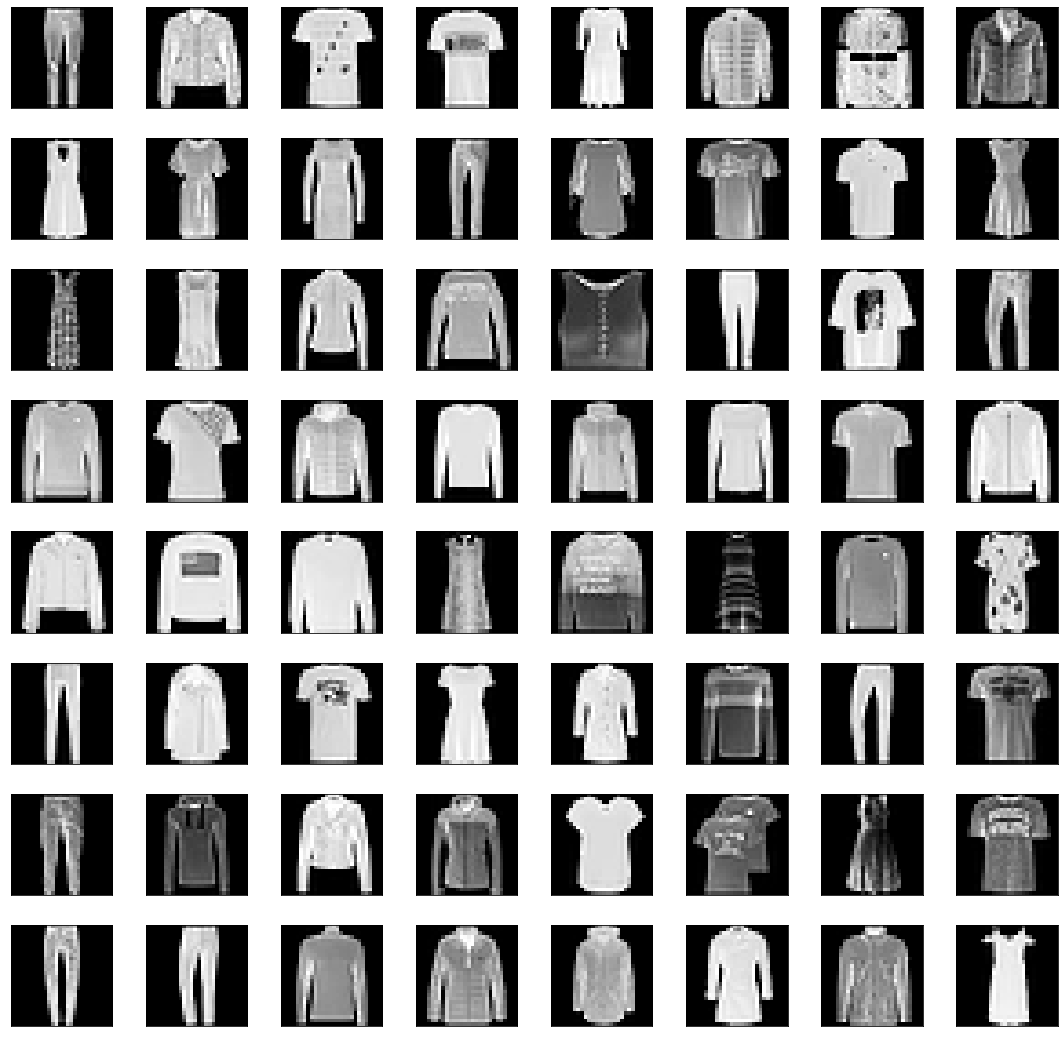

In [83]:
plot_examples()

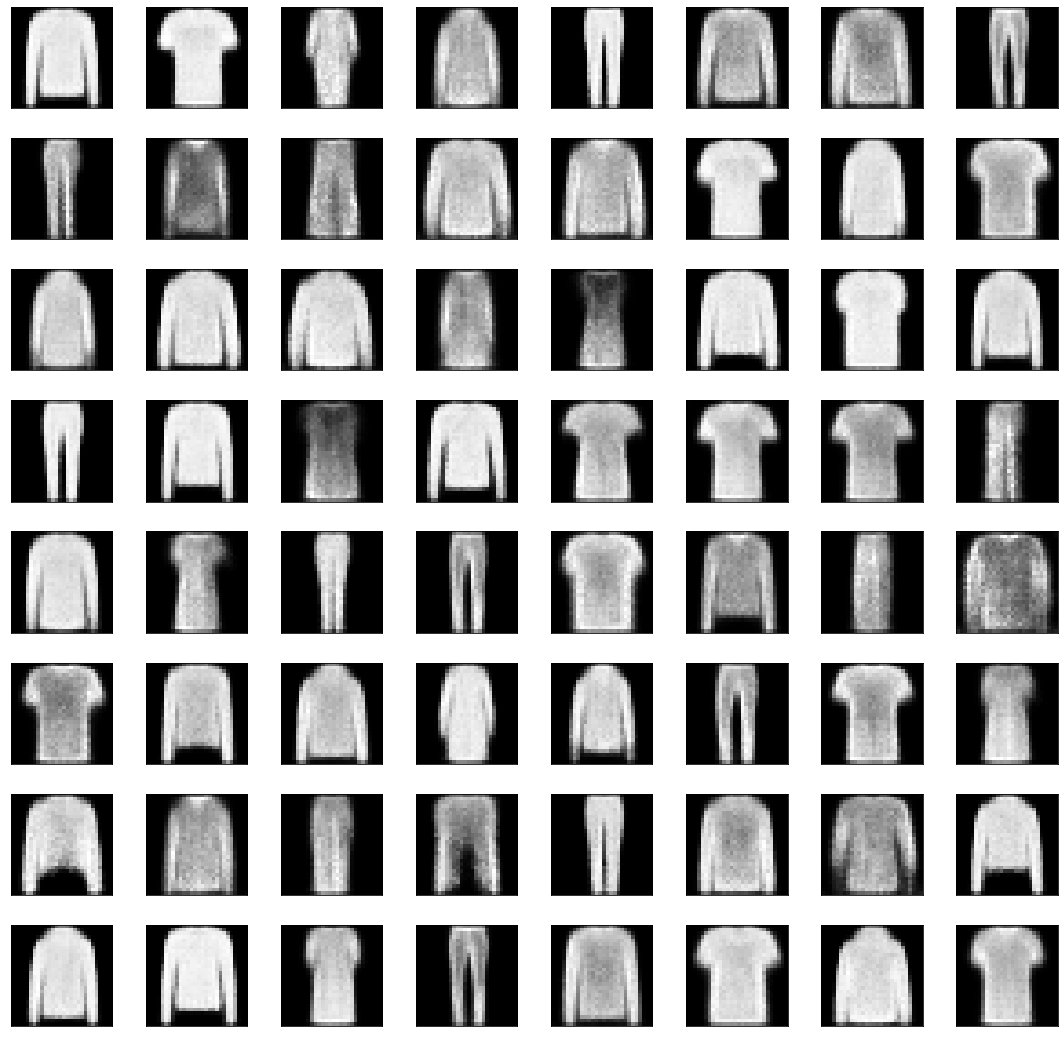

In [126]:
#Reconstructions
plot_examples(model)


In [128]:
# Sample latent space
plot_examples(model,sample=True)

StopIteration: 

In [ ]:
# 

z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)
z3 = torch.randn(1, latent_dim).to(device)
z4 = torch.randn(1, latent_dim).to(device)

y = torch.randint(0, 10,(1,1)).to(dtype=torch.long) # 10=number of classes
y = torch.nn.functional.one_hot(y,10).type(torch.float).to(device,dtype=z.dtype)[0]

z1 = torch.cat((z1,y),dim=1)
z2 = torch.cat((z2,y),dim=1)
z3 = torch.cat((z3,y),dim=1)
z4 = torch.cat((z4,y),dim=1)

print(z1)
print(z2)
print(z3)
print(z4)
rec1 = model.decode(z1)
rec2 = model.decode(z2)
rec3 = model.decode(z3)
rec4 = model.decode(z4)

img1 = rec1.view(28,28).data
img2 = rec2.view(28,28).data
img3 = rec3.view(28,28).data
img4 = rec4.view(28,28).data


In [ ]:
plt.figure()
plt.imshow(img1.to('cpu'), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(img2.to('cpu'), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(img3.to('cpu'), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(img4.to('cpu'), cmap='gray')